# Datawhale智慧海洋建设-Task4模型建立

此部分为智慧海洋建设竞赛的模型建立模块。在该模块中主要介绍了如何进行模型建立并对模型调优。

## 学习目标
1. 学习如何选择合适的模型以及如何通过模型来进行特征选择
2. 掌握随机森林、lightGBM、Xgboost模型的使用。
3. 掌握贝叶斯优化方法的具体使用

## 内容介绍
1. 模型训练与预测
 - 随机森林
 - lightGBM模型
 - Xgboost模型
2. 交叉验证
3. 模型调参
4. 智慧海洋数据集模型代码示例

# 模型训练与预测

模型训练与预测的主要步骤为：  
(1):导入需要的工具库  
(2):对数据预处理，包括导入数据集、处理数据等操作，具体为缺失值处理、连续特征归一化、类别特征转换等  
(3):训练模型。选择合适的机器学习模型，利用训练集对模型进行训练，达到最佳拟合效果。  
(4):预测结果。将待预测的数据输入到训练好的模型中，得到预测的结果。

下面进行几种常用的分类算法进行介绍

## 随机森林分类
[随机森林参数介绍](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)  
随机森林是通过集成学习的思想将多棵树集成的一种算法，基本单元是决策树，而它的本质属于机器学习的一个分支——集成学习。
随机森林模型的主要优点是：在当前算法中，具有较好的准确率；能够有效地运行在大数据集上；能够处理具有高维特征的输入样本，而且不需要降维；能够评估各个特征在分类问题上的重要性；在生成过程中，能够获取到内部生成误差的一种无偏估计；对于缺省值问题也能够获得很好的结果。  

使用sklearn调用随机森林分类树进行预测算法：

In [1]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#数据集导入
iris=datasets.load_iris()
feature=iris.feature_names
X = iris.data
y = iris.target
#随机森林
clf=RandomForestClassifier(n_estimators=200)
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.1,random_state=5)
clf.fit(train_X,train_y)
test_pred=clf.predict(test_X)

In [2]:
#特征的重要性查看
print(str(feature)+'\n'+str(clf.feature_importances_))

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0.10523326 0.02471595 0.37322056 0.49683024]


采用F1 score进行模型的评价，[此为一篇csdn中对该评价方法的简单说明](https://blog.csdn.net/qq_14997473/article/details/82684300)

In [3]:
#F1-score 用于模型评价
#如果是二分类问题则选择参数‘binary’
#如果考虑类别的不平衡性，需要计算类别的加权平均，则使用‘weighted’
#如果不考虑类别的不平衡性，计算宏平均，则使用‘macro’
score=f1_score(test_y,test_pred,average='macro')
print("随机森林-macro：",score)
score=f1_score(test_y,test_pred,average='weighted')
print("随机森林-weighted：",score)

随机森林-macro： 0.818181818181818
随机森林-weighted： 0.8


## lightGBM模型
[lightGBM的学习可参见这篇文章](https://mp.weixin.qq.com/s/64xfT9WIgF3yEExpSxyshQ)  
[lightGBM中文文档](https://lightgbm.apachecn.org/#/)这个对超参数的讲解较为详细，建议仔细阅读

1. lightGBM过拟合处理方案：
- 使用较小的 max_bin
- 使用较小的 num_leaves
- 使用 min_data_in_leaf 和 min_sum_hessian_in_leaf
- 通过设置 bagging_fraction 和 bagging_freq 来使用 bagging
- 通过设置 feature_fraction 来使用特征子抽样
- 使用更大的训练数据
- 使用 lambda_l1, lambda_l2 和 min_gain_to_split 来使用正则
- 尝试 max_depth 来避免生成过深的树  
2. lightGBM针对更快的训练速度的解决方案
- 通过设置 bagging_fraction 和 bagging_freq 参数来使用 bagging 方法
- 通过设置 feature_fraction 参数来使用特征的子抽样
- 使用较小的 max_bin
- 使用 save_binary 在未来的学习过程对数据加载进行加速
- 使用并行学习, 可参考 并行学习指南
3. lightGBM针对更好的准确率
- 使用较大的 max_bin （学习速度可能变慢）
- 使用较小的 learning_rate 和较大的 num_iterations
- 使用较大的 num_leaves （可能导致过拟合）
- 使用更大的训练数据
- 尝试 dart

In [4]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# 加载数据
iris = datasets.load_iris()
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3)
# 转换为Dataset数据格式
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)
# 参数
results = {}
params = {
    'learning_rate': 0.1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.9,
    'max_depth': 1,
    'objective': 'multiclass',  # 目标函数
    'num_class': 3,
    'verbose': -1 
}
# 模型训练
gbm = lgb.train(params, train_data, valid_sets=(validation_data,train_data),valid_names=('validate','train'),evals_result= results)
# 模型预测
y_pred_test = gbm.predict(X_test)
y_pred_data = gbm.predict(X_train)
y_pred_data = [list(x).index(max(x)) for x in y_pred_data]
y_pred_test = [list(x).index(max(x)) for x in y_pred_test]
# 模型评估
print(accuracy_score(y_test, y_pred_test))
print('训练集',f1_score(y_train, y_pred_data,average='macro'))
print('验证集',f1_score(y_test, y_pred_test,average='macro'))

[1]	train's multi_logloss: 1.00016	validate's multi_logloss: 1.03257
[2]	train's multi_logloss: 0.920085	validate's multi_logloss: 0.951757
[3]	train's multi_logloss: 0.849862	validate's multi_logloss: 0.870461
[4]	train's multi_logloss: 0.787982	validate's multi_logloss: 0.812493
[5]	train's multi_logloss: 0.732347	validate's multi_logloss: 0.747301
[6]	train's multi_logloss: 0.682533	validate's multi_logloss: 0.697048
[7]	train's multi_logloss: 0.637538	validate's multi_logloss: 0.647409
[8]	train's multi_logloss: 0.596823	validate's multi_logloss: 0.605301
[9]	train's multi_logloss: 0.559893	validate's multi_logloss: 0.562301
[10]	train's multi_logloss: 0.526067	validate's multi_logloss: 0.533205
[11]	train's multi_logloss: 0.495288	validate's multi_logloss: 0.4997
[12]	train's multi_logloss: 0.466935	validate's multi_logloss: 0.471147
[13]	train's multi_logloss: 0.44117	validate's multi_logloss: 0.44096
[14]	train's multi_logloss: 0.417224	validate's multi_logloss: 0.421709
[15]	tr

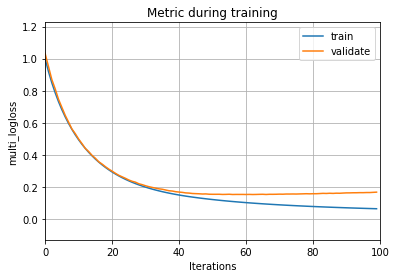

In [5]:
# 有以下曲线可知验证集的损失是比训练集的损失要高，所以模型可以判断模型出现了过拟合
lgb.plot_metric(results)
plt.show()

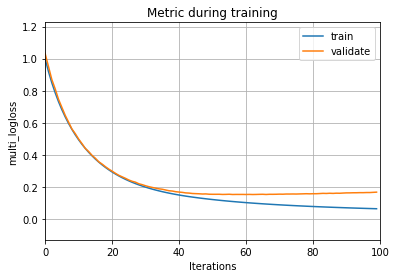

In [6]:
#因此可以尝试将lambda_l2设置为0.9
lgb.plot_metric(results)
plt.show()

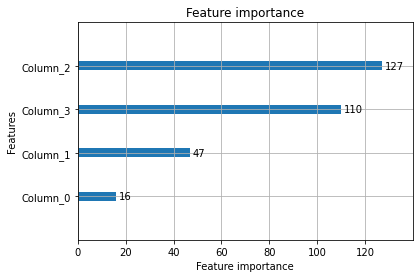

In [7]:
# 绘制重要的特征
lgb.plot_importance(gbm,importance_type = "split")
plt.show()

## xgboost模型
[XGBoost基础介绍](https://mp.weixin.qq.com/s/AAKPSIHk1iUqCeUibrORqQ)  
[XGBoost参数介绍](https://xgboost.readthedocs.io/en/latest/parameter.html)  
[XGboost参数调优方法](https://blog.csdn.net/han_xiaoyang/article/details/52665396)

F1_score: 95.56%


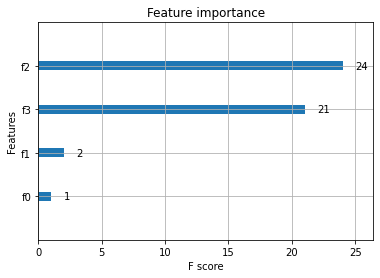

In [8]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score   # 准确率
# 加载样本数据集
iris = load_iris()
X,y = iris.data,iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234565) # 数据集分割
# 算法参数
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'eval_metric':'mlogloss',
    'num_class': 3,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.75,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1,
    'nthread': 4,
}

# plst = params.items()

train_data = xgb.DMatrix(X_train, y_train) # 生成数据集格式
num_rounds = 500
model = xgb.train(params, train_data) # xgboost模型训练

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
F1_score = f1_score(y_test,y_pred,average='macro')
print("F1_score: %.2f%%" % (F1_score*100.0))

# 显示重要特征
plot_importance(model)
plt.show()

https://blog.csdn.net/han_xiaoyang/article/details/52665396
https://www.cnblogs.com/TimVerion/p/11436001.html

# 交叉验证

交叉验证是验证分类器性能的一种统计分析方法，其基本思想在某种意义下将原始数据进行分组，一部分作为训练集，另一部分作为验证集。首先是用训练集对分类器进行训练，再利用验证集来测试所得到的的模型，以此来作为评价分类器的性能指标。常用的交叉验证方法包括简单交叉验证、K折交叉验证、留一法交叉验证和留P法交叉验证

1.简单交叉验证(cross validation)  
简单交叉验证是将原始数据分为两组，一组作为训练集，另一组作为验证集，利用训练集训练分类器，然后利用验证集验证模型，将最后的分类准确率作为此分类器的性能指标。通常是划分30%的数据作为测试数据
2.K折交叉验证(K-Fold cross validation)  
K折交叉验证是将原始数据分为K组，然后将每个子集数据分别做一次验证集，其余的K-1组子集作为训练集，这样就会得到K个模型，将K个模型最终的验证集的分类准确率取平均值，作为K折交叉验证分类器的性能指标。通常设置为K为5或者10.  
3.留一法交叉验证(Leave-One-Out Cross Validation，LOO-CV)
留一法交叉验证是指每个训练集由除一个样本之外的其余样本组成，留下的一个样本组成检验集。这样对于N个样本的数据集，可以组成N个不同的训练集和N个不同的验证集，因此该方法会得到N个模型，用N个模型最终的验证集的分类准确率的平均是作为分类器的性能指标。  
4.留P法交叉验证  
该方法与留一法类似，是从完整数据集中删除P个样本，产生所有可能的训练集和验证集。

交叉验证示例代码

1.简单交叉验证

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
#数据集导入
iris=datasets.load_iris()
feature=iris.feature_names
X = iris.data
y = iris.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=0)

2.K折交叉验证

In [12]:
from sklearn.model_selection import KFold
folds = KFold(n_splits=10, shuffle=False)

3.留一法交叉验证

In [13]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()

4.留P法交叉验证

In [14]:
from sklearn.model_selection import LeavePOut
lpo=LeavePOut(p=5)

另外还有一些其他交叉验证的分割方法，如基于类标签，具有分层的交叉验证。这一类交叉验证方法主要用于解决样本不平衡的问题。  
这种情况下常用StratifiedKFold和StratifiedShuffleSplit的分层抽样方法，可以确保相应的类别频率在每个训练和验证的(fold)中得以保留。  
StratifiedKFold：是K-fold的变种，会返回stratified(分层)的折叠：每个小集合中的各个类别的样本比例大致和完整数据集相同。  
StratifiedShuffleSplit:是ShuffleSplit的一种变种，会返回直接的划分，比如创建一个划分，但是划分中的每个类的比例和完整数据集中的相同。

# 模型调参
调参就是对模型的参数进行调整，找到使模型最优的超参数，调参的目标就是尽可能达到整体模型的最优

1.网格搜索  
网格搜索就是一种穷举搜索，在所有候选的参数选择中通过循环遍历去在所有候选参数中寻找表现最好的结果。

2.学习曲线  
学习曲线是在训练集大小不同时通过绘制模型训练集和交叉验证集上的准确率来观察模型在新数据上的表现，进而来判断模型是否方差偏高或偏差过高，以及增大训练集是否可以减小过拟合。  

<img src="https://img-blog.csdn.net/20180207143722125?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvZGF0b3V0b25nXw==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast" alt="img" style="zoom:50%;" />
1、当训练集和测试集的误差收敛但却很高时，为高偏差。   

左上角的偏差很高，训练集和验证集的准确率都很低，很可能是欠拟合。   
我们可以增加模型参数，比如，构建更多的特征，减小正则项。   
此时通过增加数据量是不起作用的。
  
2、当训练集和测试集的误差之间有大的差距时，为高方差。   

当训练集的准确率比其他独立数据集上的测试结果的准确率要高时，一般都是过拟合。   
右上角方差很高，训练集和验证集的准确率相差太多，应该是过拟合。   
我们可以增大训练集，降低模型复杂度，增大正则项，或者通过特征选择减少特征数。  
理想情况是是找到偏差和方差都很小的情况，即收敛且误差较小。

3.验证曲线
和学习曲线不同，验证曲线的横轴为某个超参数的一系列值，由此比较不同超参数设置下的模型准确值。从下图的验证曲线可以看到，随着超参数设置的改变，模型可能会有从欠拟合到合适再到过拟合的过程，进而可以选择一个合适的超参数设置来提高模型的性能。
![image.png](attachment:image.png)

In [15]:
#以Xgboost为例，该网格搜索代码示例如下
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV

cancer = load_breast_cancer()
x = cancer.data[:50]
y = cancer.target[:50]
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.333, random_state=0)  # 分训练集和验证集
# 这里不需要Dmatrix

parameters = {
    'max_depth': [5, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 200, 300, 500],
    'min_child_weight': [0, 2, 5, 10, 20],
    'max_delta_step': [0, 0.2, 0.6, 1, 2],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
    'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
}

xlf = xgb.XGBClassifier(max_depth=10,
                        learning_rate=0.01,
                        n_estimators=2000,
                        silent=True,
                        objective='binary:logistic',
                        nthread=-1,
                        gamma=0,
                        min_child_weight=1,
                        max_delta_step=0,
                        subsample=0.85,
                        colsample_bytree=0.7,
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1,
                        scale_pos_weight=1,
                        seed=1440,
                        missing=None)

# 有了gridsearch我们便不需要fit函数
gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(train_x, train_y)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
#极其耗费时间,电脑没执行完

# 智慧海洋数据集模型代码示例

## lightGBM模型

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, KFold,train_test_split
import lightgbm as lgb
import os
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
all_df=pd.read_csv('group_df.csv',index_col=0)

In [7]:
use_train = all_df[all_df['label'] != -1]
use_test = all_df[all_df['label'] == -1]#label为-1时是测试集
use_feats = [c for c in use_train.columns if c not in ['ID', 'label']]
X_train,X_verify,y_train,y_verify= train_test_split(use_train[use_feats],use_train['label'],test_size=0.3,random_state=0)

1.根据特征的重要性进行特征选择

In [10]:
##############特征选择参数###################
selectFeatures = 200 # 控制特征数
earlyStopping = 100 # 控制早停
select_num_boost_round = 1000 # 特征选择训练轮次
#首先设置基础参数
selfParam = {
    'learning_rate':0.01, # 学习率
    'boosting':'dart', # 算法类型, gbdt,dart
    'objective':'multiclass', # 多分类
    'metric':'None',
    'num_leaves':32, # 
    'feature_fraction':0.7, # 训练特征比例
    'bagging_fraction':0.8, # 训练样本比例 
    'min_data_in_leaf':30, # 叶子最小样本
    'num_class': 3,
    'max_depth':6, # 树的最大深度
    
    'num_threads':8,#LightGBM 的线程数
    'min_data_in_bin':30, # 单箱数据量
    'max_bin':256, # 最大分箱数 
    'is_unbalance':True, # 非平衡样本
    'train_metric':True,
    'verbose':-1,
}
# 特征选择 ---------------------------------------------------------------------------------
def f1_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.argmax(preds.reshape(3, -1), axis=0)
    scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'f1_score', scores, True

train_data = lgb.Dataset(data=X_train,label=y_train,feature_name=use_feats)
valid_data = lgb.Dataset(data=X_verify,label=y_verify,reference=train_data,feature_name=use_feats)

sm = lgb.train(params=selfParam,train_set=train_data,num_boost_round=select_num_boost_round,
                      valid_sets=[valid_data],valid_names=['valid'],
                      feature_name=use_feats,
                      early_stopping_rounds=earlyStopping,verbose_eval=False,keep_training_booster=True,feval=f1_score_eval)
features_importance = {k:v for k,v in zip(sm.feature_name(),sm.feature_importance(iteration=sm.best_iteration))}
sort_feature_importance = sorted(features_importance.items(),key=lambda x:x[1],reverse=True)
print('total feature best score:', sm.best_score)
print('total feature importance:',sort_feature_importance)
print('select forward {} features:{}'.format(selectFeatures,sort_feature_importance[:selectFeatures]))
#model_feature是选择的超参数
model_feature = [k[0] for k in sort_feature_importance[:selectFeatures]]

D:\SOFTWEAR_H\Anaconda3\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


total feature best score: defaultdict(<class 'collections.OrderedDict'>, {'valid': OrderedDict([('f1_score', 0.9004541298211368)])})
total feature importance: [('pos_neq_zero_speed_q_40', 1783), ('lat_lon_countvec_1_x', 1771), ('rank2_mode_lat', 1737), ('pos_neq_zero_speed_median', 1379), ('pos_neq_zero_speed_q_60', 1369), ('lat_lon_tfidf_0_x', 1251), ('pos_neq_zero_speed_q_80', 1194), ('sample_tfidf_0_x', 1168), ('w2v_9_mean', 1134), ('lat_lon_tfidf_11_x', 963), ('rank3_mode_lat', 946), ('w2v_5_mean', 900), ('w2v_16_mean', 874), ('pos_neq_zero_speed_q_30', 866), ('w2v_12_mean', 862), ('pos_neq_zero_speed_q_70', 856), ('lat_lon_tfidf_9_x', 787), ('grad_tfidf_7_x', 772), ('pos_neq_zero_speed_q_90', 746), ('rank3_mode_cnt', 733), ('grad_tfidf_12_x', 729), ('w2v_4_mean', 697), ('sample_tfidf_14_x', 695), ('lat_lon_tfidf_4_x', 693), ('lat_min', 683), ('w2v_23_mean', 647), ('rank2_mode_lon', 631), ('w2v_26_mean', 626), ('rank1_mode_lon', 620), ('grad_tfidf_15_x', 607), ('speed_neq_zero_spee

[贝叶斯优化介绍](https://github.com/FontTian/hyperopt-doc-zh/wiki/FMin)也是在建模调参过程中常用的一种方法，下面是通过贝叶斯优化进行超参数选择的代码

In [40]:
##############超参数优化的超参域###################
spaceParam = {
    'boosting': hp.choice('boosting',['gbdt','dart']),
    'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.05)),
    'num_leaves': hp.quniform('num_leaves', 3, 66, 3), 
    'feature_fraction': hp.uniform('feature_fraction', 0.7,1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 50,5), 
    'num_boost_round':hp.quniform('num_boost_round',500,2000,100), 
    'bagging_fraction':hp.uniform('bagging_fraction',0.6,1)  
}
# 超参数优化 ---------------------------------------------------------------------------------
def getParam(param):
    for k in ['num_leaves', 'min_data_in_leaf','num_boost_round']:
        param[k] = int(float(param[k]))
    for k in ['learning_rate', 'feature_fraction','bagging_fraction']:
        param[k] = float(param[k])
    if param['boosting'] == 0:
        param['boosting'] = 'gbdt'
    elif param['boosting'] == 1:
        param['boosting'] = 'dart'
    # 添加固定参数
    param['objective'] = 'multiclass'
    param['max_depth'] = 7
    param['num_threads'] = 8
    param['is_unbalance'] = True
    param['metric'] = 'None'
    param['train_metric'] = True
    param['verbose'] = -1
    param['bagging_freq']=5
    param['num_class']=3 
    param['feature_pre_filter']=False
    return param
def f1_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.argmax(preds.reshape(3, -1), axis=0)
    scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'f1_score', scores, True
def lossFun(param):
    param = getParam(param)
    m = lgb.train(params=param,train_set=train_data,num_boost_round=param['num_boost_round'],
                          valid_sets=[train_data,valid_data],valid_names=['train','valid'],
                          feature_name=features,feval=f1_score_eval,
                          early_stopping_rounds=earlyStopping,verbose_eval=False,keep_training_booster=True)
    train_f1_score = m.best_score['train']['f1_score']
    valid_f1_score = m.best_score['valid']['f1_score']
    loss_f1_score = 1 - valid_f1_score
    print('训练集f1_score:{},测试集f1_score:{},loss_f1_score:{}'.format(train_f1_score, valid_f1_score, loss_f1_score))
    return {'loss': loss_f1_score, 'params': param, 'status': STATUS_OK}

features = model_feature
train_data = lgb.Dataset(data=X_train[model_feature],label=y_train,feature_name=features)
valid_data = lgb.Dataset(data=X_verify[features],label=y_verify,reference=train_data,feature_name=features)

best_param = fmin(fn=lossFun, space=spaceParam, algo=tpe.suggest, max_evals=100, trials=Trials())
best_param = getParam(best_param)
print('Search best param:',best_param)

训练集f1_score:1.0,测试集f1_score:0.9238060849905194,loss_f1_score:0.07619391500948058                                       
训练集f1_score:0.9414337502771342,测试集f1_score:0.8878751759836653,loss_f1_score:0.11212482401633472                        
训练集f1_score:1.0,测试集f1_score:0.9275451088133652,loss_f1_score:0.07245489118663484                                       
训练集f1_score:1.0,测试集f1_score:0.9262405937033683,loss_f1_score:0.07375940629663169                                       
训练集f1_score:0.9708237804866381,测试集f1_score:0.9105982243190386,loss_f1_score:0.08940177568096142                        
训练集f1_score:0.9689912364726484,测试集f1_score:0.9086459359345839,loss_f1_score:0.09135406406541613                        
训练集f1_score:0.9841597696688008,测试集f1_score:0.9027075194168233,loss_f1_score:0.09729248058317674                        
训练集f1_score:1.0,测试集f1_score:0.9215512877825286,loss_f1_score:0.0784487122174714                                        
训练集f1_score:1.0,测试集f1_score:0.9245554519

经过特征选择和超参数优化后，最终的模型使用为将参数设置为贝叶斯优化之后的超参数，然后进行5折交叉，对测试集进行叠加求平均。

In [42]:
def f1_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.argmax(preds.reshape(3, -1), axis=0)
    scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'f1_score', scores, True

def sub_on_line_lgb(train_, test_, pred, label, cate_cols, split,
                    is_shuffle=True,
                    use_cart=False,
                    get_prob=False):
    n_class = 3
    train_pred = np.zeros((train_.shape[0], n_class))
    test_pred = np.zeros((test_.shape[0], n_class))
    n_splits = 5

    assert split in ['kf', 'skf'
                    ], '{} Not Support this type of split way'.format(split)

    if split == 'kf':
        folds = KFold(n_splits=n_splits, shuffle=is_shuffle, random_state=1024)
        kf_way = folds.split(train_[pred])
    else:
        #与KFold最大的差异在于，他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同。
        folds = StratifiedKFold(n_splits=n_splits,
                                shuffle=is_shuffle,
                                random_state=1024)
        kf_way = folds.split(train_[pred], train_[label])

    print('Use {} features ...'.format(len(pred)))
    #将以下参数改为贝叶斯优化之后的参数
    params = {
        'learning_rate': 0.05,
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'None',
        'num_leaves': 60,
        'feature_fraction':0.86,
        'bagging_fraction': 0.73,
        'bagging_freq': 5,
        'seed': 1,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 15,
        'num_class': n_class,
        'nthread': 8,
        'verbose': -1,
        'num_boost_round': 1100,
        'max_depth': 7,
    }
    for n_fold, (train_idx, valid_idx) in enumerate(kf_way, start=1):
        print('the {} training start ...'.format(n_fold))
        train_x, train_y = train_[pred].iloc[train_idx
                                            ], train_[label].iloc[train_idx]
        valid_x, valid_y = train_[pred].iloc[valid_idx
                                            ], train_[label].iloc[valid_idx]

        if use_cart:
            dtrain = lgb.Dataset(train_x,
                                 label=train_y,
                                 categorical_feature=cate_cols)
            dvalid = lgb.Dataset(valid_x,
                                 label=valid_y,
                                 categorical_feature=cate_cols)
        else:
            dtrain = lgb.Dataset(train_x, label=train_y)
            dvalid = lgb.Dataset(valid_x, label=valid_y)

        clf = lgb.train(params=params,
                        train_set=dtrain,
#                         num_boost_round=3000,
                        valid_sets=[dvalid],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        feval=f1_score_eval)
        train_pred[valid_idx] = clf.predict(valid_x,
                                            num_iteration=clf.best_iteration)
        test_pred += clf.predict(test_[pred],
                                 num_iteration=clf.best_iteration) / folds.n_splits
    print(classification_report(train_[label], np.argmax(train_pred,
                                                         axis=1),
                                digits=4))
    if get_prob:
        sub_probs = ['qyxs_prob_{}'.format(q) for q in ['围网', '刺网', '拖网']]
        prob_df = pd.DataFrame(test_pred, columns=sub_probs)
        prob_df['ID'] = test_['ID'].values
        return prob_df
    else:
        test_['label'] = np.argmax(test_pred, axis=1)
        return test_[['ID', 'label']]

use_train = all_df[all_df['label'] != -1]
use_test = all_df[all_df['label'] == -1]
# use_feats = [c for c in use_train.columns if c not in ['ID', 'label']]
use_feats=model_feature
sub = sub_on_line_lgb(use_train, use_test, use_feats, 'label', [], 'kf',is_shuffle=True,use_cart=False,get_prob=False)

Use 200 features ...
the 1 training start ...
Training until validation scores don't improve for 100 rounds


D:\SOFTWEAR_H\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's f1_score: 0.894256
[200]	valid_0's f1_score: 0.909942
[300]	valid_0's f1_score: 0.913423
[400]	valid_0's f1_score: 0.917897
[500]	valid_0's f1_score: 0.920616
Early stopping, best iteration is:
[456]	valid_0's f1_score: 0.920717
the 2 training start ...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.918357
[200]	valid_0's f1_score: 0.916436
Early stopping, best iteration is:
[140]	valid_0's f1_score: 0.92449
the 3 training start ...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.915242
[200]	valid_0's f1_score: 0.927189
[300]	valid_0's f1_score: 0.930614
Early stopping, best iteration is:
[238]	valid_0's f1_score: 0.930614
the 4 training start ...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's f1_score: 0.901683
[200]	valid_0's f1_score: 0.912985
[300]	valid_0's f1_score: 0.916988
[400]	valid_0's f1_score: 0.92147
[500]	valid_0's f1_score: 0.921353
Early 

<ipython-input-42-6cbdd079efb6>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_['label'] = np.argmax(test_pred, axis=1)
